# Experiment 7
In this experiment, we get back to adversarial training like USAD after modifying the Graph autoencoder, here we add another GCNLayer

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch.optim import Adam
from torch_geometric.nn import GAE, VGAE, GCNConv
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score

### Dataset:

In [2]:
df = pd.read_csv('../../Projects/data/SWaT_Dataset_Normal_v1.csv')
df = df.drop(columns=[' Timestamp', 'Normal/Attack'])
df = df.astype('float64')
df = df.iloc[21600:]
mm = StandardScaler()
Normalized = pd.DataFrame(mm.fit_transform(df))
train_set = Normalized[: int(0.8 * Normalized.shape[0])]
validation_set = Normalized[int(0.8 * Normalized.shape[0]):]

In [3]:
class SWat_dataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, target: pd.DataFrame,  window_size):
        self.data = dataframe
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        window = self.data[idx: idx + self.window_size]
        features = torch.tensor(window.iloc[:,:].values).float().to(device)
        return features

### Dataloader:

In [4]:
window_size = 50
input_size = window_size * 51
latent_space = 10 * window_size
epochs = 50

In [5]:
train_dataset = SWat_dataset(train_set, train_set, window_size)
validation_dataset = SWat_dataset(validation_set, validation_set, window_size)

batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

### Model:

In [6]:
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.dense = nn.Linear(in_dim, out_dim)
        self.bn = nn.BatchNorm1d(out_dim)

    def forward(self, adj, X):
        adj = adj + torch.eye(adj.size(0)).to(adj.device)
        h = self.dense(X)
        norm = adj.sum(1)**(-1/2)
        h = norm[None, :] * adj * norm[:, None] @ h
        h = h.permute(0,2,1)
        h = self.bn(h)
        h = h.permute(0,2,1)
        return h
    
    
# A = ReLu(W)    
class Graph_ReLu_W(nn.Module):
    def __init__(self, num_nodes, k, device):
        super(Graph_ReLu_W, self).__init__()
        self.num_nodes = num_nodes
        self.k = k
        self.A = nn.Parameter(torch.randn(num_nodes, num_nodes).to(device), requires_grad=True).to(device)

    def forward(self, idx):
        
        adj = F.relu(self.A)
        
        if self.k:
            mask = torch.zeros(idx.size(0), idx.size(0)).to(self.device)
            mask.fill_(float('0'))
            s1,t1 = (adj + torch.rand_like(adj)*0.01).topk(self.k,1)
            mask.scatter_(1,t1,s1.fill_(1))
            adj = adj*mask
            
        return adj

# A for Directed graphs:
class Graph_Directed_A(nn.Module):
      
    def __init__(self, num_nodes, window_size, alpha, k, device):
        super(Graph_Directed_A, self).__init__()
        
        self.alpha = alpha
        self.k = k
        self.device = device
        
        self.e1 = nn.Embedding(num_nodes, window_size)
        self.e2 = nn.Embedding(num_nodes, window_size)
        self.l1 = nn.Linear(window_size,window_size)
        self.l2 = nn.Linear(window_size,window_size)
        
    def forward(self, idx):
        
        m1 = torch.tanh(self.alpha*self.l1(self.e1(idx)))
        m2 = torch.tanh(self.alpha*self.l2(self.e2(idx)))
        adj = F.relu(torch.tanh(self.alpha*torch.mm(m1, m2.transpose(1,0))))
        
        if self.k:
            mask = torch.zeros(idx.size(0), idx.size(0)).to(self.device)
            mask.fill_(float('0'))
            s1,t1 = (adj + torch.rand_like(adj)*0.01).topk(self.k,1)
            mask.scatter_(1,t1,s1.fill_(1))
            adj = adj*mask
        
        return adj

In [21]:
class GCNEncoder(nn.Module):
    def __init__(self, num_nodes, window_size, hidden_nodes, k, device):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNLayer(window_size, window_size // 2)
        self.conv2 = GCNLayer(window_size // 2, window_size // 2)
        self.conv3 = GCNLayer(window_size // 2, window_size)
        self.idx = torch.arange(num_nodes).to(device)
        self.A = Graph_ReLu_W(num_nodes, k, device)
        
    def forward(self, X):
        adj = self.A(self.idx)
        h = self.conv1(adj, X).relu()
        h = self.conv2(adj, h).relu()
        return self.conv3(adj, h)

In [22]:
num_nodes = 51 # number of nodes
ngnn = 1 # number of graph structure learning layers
gsllayer = 'directed' # type of graph structure learning layer ('relu', 'directed', 'unidirected', 'undirected')
hidden_nodes = 50 # feature size in GCN layers
alpha = 0.1 # hyperparameter for weights of edges
k = None # max number of edges for each node
out_channels = 2 # number of process states

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [24]:
shared_encoder = GCNEncoder(num_nodes, window_size, hidden_nodes, k, device)
AE1 = GAE(shared_encoder)
AE2 = GAE(shared_encoder)

In [25]:
AE1.to(device)
AE2.to(device)

GAE(
  (encoder): GCNEncoder(
    (conv1): GCNLayer(
      (dense): Linear(in_features=50, out_features=25, bias=True)
      (bn): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): GCNLayer(
      (dense): Linear(in_features=25, out_features=25, bias=True)
      (bn): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): GCNLayer(
      (dense): Linear(in_features=25, out_features=50, bias=True)
      (bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (A): Graph_ReLu_W()
  )
  (decoder): InnerProductDecoder()
)

In [26]:
optimizer1 = torch.optim.Adam(AE1.parameters())
optimizer2 = torch.optim.Adam(AE2.parameters())

In [19]:
from torch.utils.tensorboard import SummaryWriter

In [27]:
# writer = SummaryWriter('runs/GAE_' + f'{epochs}_epochs' + 'only autoencoder')
AE1_val_history = []
AE2_val_history = []
for i in range(epochs):
    running_loss_AE1 = []
    running_loss_AE2 = []
    val_loss_AE1 = []
    val_loss_AE2 = []
    for index_b, features in enumerate(train_loader):
        features = torch.transpose(features, 1, 2)
        
        w1 = AE1(features)
        w2 = AE2(features)
        w3 = AE2(w1)
        lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        
        running_loss_AE1.append(lossAE1)
        lossAE1.backward()
        optimizer1.step()
        optimizer1.zero_grad()
        
        w1 = AE1(features)
        w2 = AE2(features)
        w3 = AE2(w1)
        lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        
        running_loss_AE2.append(lossAE2)
        lossAE2.backward()
        optimizer2.step()
        optimizer2.zero_grad()
    
    for index_b, features in enumerate(validation_loader):
        with torch.no_grad():
            features = torch.transpose(features, 1, 2)
        
            w1 = AE1(features)
            w2 = AE2(features)
            w3 = AE2(w1)
            lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
            lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
            val_loss_AE1.append(lossAE1)
            val_loss_AE2.append(lossAE2)
    AE1_val_history.append(torch.stack(val_loss_AE1).mean().item())
    AE2_val_history.append(torch.stack(val_loss_AE2).mean().item())
    print(f'Epoch: {i} ---> Val loss: AE1 {AE1_val_history[-1]:.4f}, AE2: {AE2_val_history[-1]:.4f}')
    print(f'Train loss: AE1 {torch.stack(running_loss_AE1).mean().item():.4f}, AE2 {torch.stack(running_loss_AE2).mean().item():.4f}')

Epoch: 0 ---> Val loss: AE1 0.9912, AE2: 0.9912
Train loss: AE1 1.2682, AE2 1.2647
Epoch: 1 ---> Val loss: AE1 0.8448, AE2: -0.1040
Train loss: AE1 1.0115, AE2 -0.0588
Epoch: 2 ---> Val loss: AE1 0.8276, AE2: -0.4103
Train loss: AE1 0.9225, AE2 -0.4073
Epoch: 3 ---> Val loss: AE1 0.9052, AE2: -0.6129
Train loss: AE1 0.9688, AE2 -0.6050
Epoch: 4 ---> Val loss: AE1 0.9820, AE2: -0.7598
Train loss: AE1 1.0426, AE2 -0.7597
Epoch: 5 ---> Val loss: AE1 1.0343, AE2: -0.8570
Train loss: AE1 1.1004, AE2 -0.8704
Epoch: 6 ---> Val loss: AE1 1.0825, AE2: -0.9349
Train loss: AE1 1.1420, AE2 -0.9527
Epoch: 7 ---> Val loss: AE1 1.1152, AE2: -0.9901
Train loss: AE1 1.1813, AE2 -1.0167
Epoch: 8 ---> Val loss: AE1 1.1426, AE2: -1.0330
Train loss: AE1 1.2125, AE2 -1.0692
Epoch: 9 ---> Val loss: AE1 1.1599, AE2: -1.0644
Train loss: AE1 1.2367, AE2 -1.1123
Epoch: 10 ---> Val loss: AE1 1.1788, AE2: -1.0947
Train loss: AE1 1.2594, AE2 -1.1482
Epoch: 11 ---> Val loss: AE1 1.1979, AE2: -1.1219
Train loss: AE1 

In [44]:
features.shape

torch.Size([4096, 51, 200])

# Testing

In [28]:
df2 = pd.read_csv('../../Projects/data/SWaT_Dataset_Attack_v0.csv')
labels = df2['Normal/Attack']
df2 = df2.drop(columns=[' Timestamp', 'Normal/Attack'])
df2 = df2.astype('float64')
df2.columns = df.columns

In [35]:
df2.shape

(449919, 51)

In [29]:
test_normalized = pd.DataFrame(mm.transform(df2))

In [30]:
test_dataset = SWat_dataset(test_normalized, test_normalized, window_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [31]:
def testing(test_loader, alpha=.5, beta=.5):
    results=[]
    with torch.no_grad():
        for batch in test_loader:
            batch = torch.transpose(batch, 1, 2)
            w1=AE1(batch)
            results.append(torch.mean(torch.mean((batch-w1)**2, axis=1), axis=1))
    return results

In [32]:
labels = labels.values
labels = [0 if (lab == 'Normal') else 1 for lab in labels]

In [33]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int32(labels[i:i+window_size])))

In [34]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels]

In [35]:
results=testing(test_loader, alpha=0.3, beta=0.7)

In [36]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

In [37]:
def ROC(y_test,y_pred):
    fpr,tpr,tr=roc_curve(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    idx=np.argwhere(np.diff(np.sign(tpr-(1-fpr)))).flatten()

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(fpr,1-fpr,'r:')
    plt.plot(fpr[idx],tpr[idx], 'ro')
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    return tr[idx]

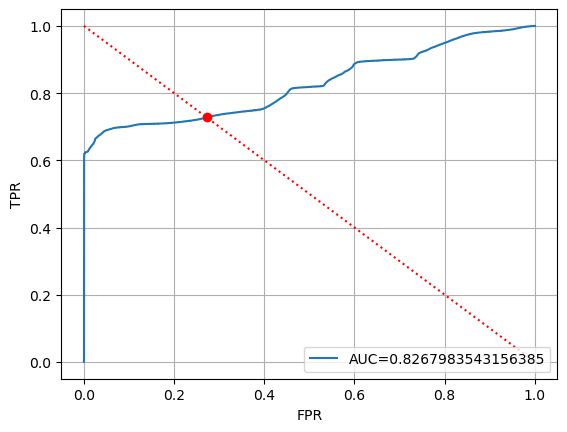

array([7.2840185], dtype=float32)

In [38]:
threshold = ROC(y_test,y_pred)
threshold

best: 32.30612244897959 F1: 0.7629016925447175


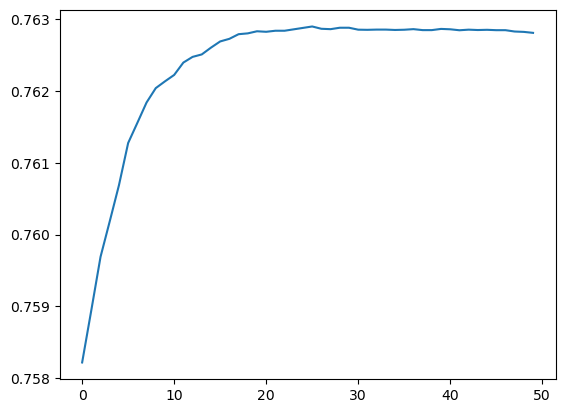

In [41]:
ff = 0
f_history = []
initial_y = 17
best = -1
for inc in np.linspace(0, 30, 50):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc
print(f'best: {best + initial_y} F1: {ff}')
plt.plot(f_history)

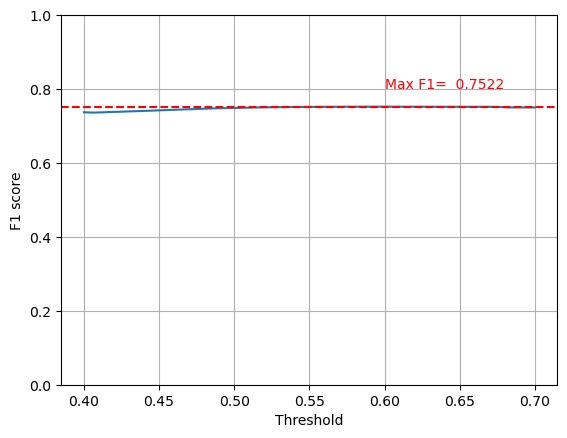

In [35]:
x_vals = 0.4 + np.linspace(0, 0.3, 50)
plt.plot(x_vals, f_history)
plt.xlabel('Threshold')
plt.ylabel('F1 score')

max_y = max(f_history)
max_x = np.argmax(f_history)
plt.axhline(y=max_y, color='r', linestyle='--', label='Max Y')
plt.text(0.6, max_y + 0.05, f'Max F1= {max_y: .4f}', color='r')
plt.ylim(0, 1)
plt.grid(True)

plt.savefig('my_plot.png')

plt.show()

In [42]:
y_pred_int = [1 if (yy > 32.3061) else 0 for yy in y_pred]
conf_matrix = confusion_matrix(y_test, y_pred_int)
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
F1 = f1_score(y_test, y_pred_int)

precision = precision_score(y_test, y_pred_int)
recall = recall_score(y_test, y_pred_int)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", F1)
print(f'TP: {TP}\nTN: {TN}\nFP: {FP}\nFN: {FN}')

Precision: 0.9920150038362081
Recall: 0.6197628177815652
F1 Score: 0.7629016925447175
TP: 34910
TN: 393260
FP: 281
FN: 21418
